Research Question: Can student-written RateMyProfessors comments be used to predict numerical professor ratings?

The dataset used in this project will be a publicly available data set from Huggingface, you can access the dataset from this link: https://huggingface.co/datasets/ZephyrUtopia/ratemyprofessors_reviews
If you see GPT anywhere please understand that I took some help from GPT to write that piece of code

Load the dataset from Hugging Face

In [2]:
from datasets import load_dataset
#Load the dataset from the site of Hugging Face
dataset = load_dataset("ZephyrUtopia/ratemyprofessors_reviews")
print(dataset)

/Users/bikki/Documents/Projects_Spring_2026/SOSC314/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['name', 'text', 'rating', 'difficulty', 'date'],
        num_rows: 336239
    })
    test: Dataset({
        features: ['name', 'text', 'rating', 'difficulty', 'date'],
        num_rows: 144103
    })
})


Convert the dataset to pandas array

In [3]:
import pandas as pd
#GPT: Make a dataframe df which has all the data from the dataset of Hugging face
#as pandas array
df = pd.concat(
    [dataset[split].to_pandas() for split in dataset.keys()],
    ignore_index=True
)
print(df.columns)
print(df.shape)

Index(['name', 'text', 'rating', 'difficulty', 'date'], dtype='object')
(480342, 5)


Some basic printing functions to see some of the observations

In [4]:
#Don't get confused with the output, in some of the cases when pandas cannot squeeze data, it divides
#the data in the way as shows in the output
print(df)
print(df["text"].head())
print(df["rating"].value_counts())
print(df["rating"].describe()) #rating is still not numeric, so this does not give too much information
print(df.describe())
print(pd.to_numeric(df["rating"], errors = "coerce").describe()) #converting rating to numerical value coerce will assign
#NaN value to missing or invalid data, also here describe will give all the parameters it gives for numericals

                        name  \
0               Leila Hawana   
1              Gloria Magana   
2          Teresa Canganelli   
3                Kumar Ankit   
4               Irina Garces   
...                      ...   
480337        Crystal Koenig   
480338        Karen Caldwell   
480339        Andrew Hudnall   
480340  David-James Gonzalez   
480341          Tyler Vouros   

                                                     text rating difficulty  \
0       Although the homework is not too much, they ar...    4.0        5.0   
1       Where can I start she's a very tough grader. H...    1.0        5.0   
2       She is a wonderful professor! Very interactive...    5.0        4.0   
3       Study solutions had incorrect answers taken fr...    1.0        4.0   
4       Super nice and helpful. Was always there in of...    5.0        4.0   
...                                                   ...    ...        ...   
480337  Amazing! Dr. Koenig gives the best lectures of...    5

Add some demo of the plots using seaborn

In [5]:
%pip install seaborn
%pip install matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Bar chart for frequency count of each of the ratings

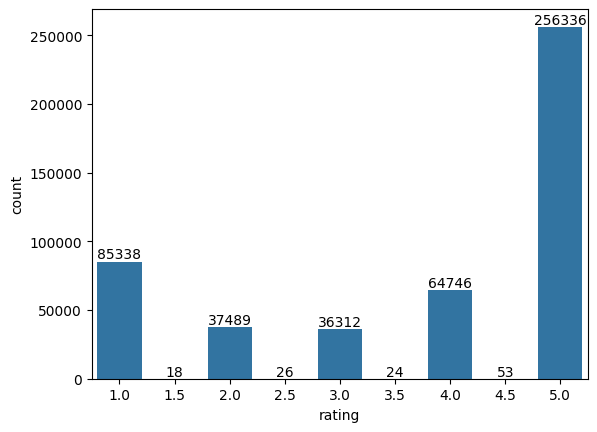

In [6]:
#GPT: Create a bar graph showing the frequency of each rating value
#Ratings are ordered in ascending order
ax = sns.countplot(
    data=df,
    x="rating",
    order=sorted(df["rating"].dropna().unique())
)
#Add frequency labels on top of each bar
#In matplot/seaborn, bars are store in "containers", so this loop goes to every bar in iterations
for container in ax.containers:
    ax.bar_label(container)
#Display the plot, in jupyter notebook this graph is shown even without the following line, but it might not be the case for .py or
#other coding environments, so writing the following line ensures portability
plt.show()


Make a new dataset that has rating as numerical rather than string

In [7]:
#Make a new dataset df_num where we'll make changes to the dataset df and have numerical values for rating
df_num = df.copy()
df_num["rating"] = pd.to_numeric(df["rating"], errors = "coerce")

#Sanity checks (better than printing the entire dataframe)
print(df_num["rating"].dtype)
print(df_num.shape)

float64
(480342, 5)


Remove the observations with rating as 1.5, 2.5, 3.5 or 4.5

In [8]:
#Check the divisibility of the dating by 1, if its not divisible by 1 
#(if its a float with some value after the decimal) remove those observations
df_num = df_num[df_num["rating"] % 1 == 0]
df_num = df_num.reset_index(drop=True)

#Sanity checks
print(df_num.shape)
print(df_num["rating"].value_counts().sort_index())

(480221, 5)
rating
1.0     85338
2.0     37489
3.0     36312
4.0     64746
5.0    256336
Name: count, dtype: int64


## Week 3: Completing Data Construction & Measurement

Now we'll complete the data cleaning, create comprehensive descriptive statistics, and prepare the dataset for modeling.

In [9]:
# Check for missing values in our cleaned dataset
print("Missing values in cleaned dataset:")
print(df_num.isnull().sum())
print("\n" + "="*50 + "\n")

# Check for duplicate reviews
duplicates = df_num.duplicated(subset=['text']).sum()
print(f"Number of duplicate reviews (based on text): {duplicates}")
print(f"Percentage of duplicates: {(duplicates/len(df_num)*100):.2f}%")

Missing values in cleaned dataset:
name          0
text          0
rating        0
difficulty    0
date          0
dtype: int64


Number of duplicate reviews (based on text): 0
Percentage of duplicates: 0.00%


In [10]:
# Remove duplicate reviews (keep first occurrence)
df_clean = df_num.drop_duplicates(subset=['text'], keep='first')
df_clean = df_clean.reset_index(drop=True)

print(f"Original size after removing half-ratings: {len(df_num)}")
print(f"After removing duplicates: {len(df_clean)}")
print(f"Removed {len(df_num) - len(df_clean)} duplicate reviews")

Original size after removing half-ratings: 480221
After removing duplicates: 480221
Removed 0 duplicate reviews


### Text Cleaning and Preprocessing
We'll clean the review text by handling basic issues like extra whitespace, but preserve meaningful content.

In [11]:
import re

def clean_text(text):
    
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove extra whitespace (tabs, newlines, multiple spaces)
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply text cleaning
df_clean['text_cleaned'] = df_clean['text'].apply(clean_text)

# Show examples of cleaning
print("Examples of text cleaning:")
for i in range(3):
    print(f"\nOriginal: {df_clean['text'].iloc[i][:100]}...")
    print(f"Cleaned:  {df_clean['text_cleaned'].iloc[i][:100]}...")

Examples of text cleaning:

Original: Although the homework is not too much, they are difficult. I should work hard for this course....
Cleaned:  although the homework is not too much, they are difficult. i should work hard for this course....

Original: Where can I start she's a very tough grader. Her tests and quizzes , and the essays do not correlate...
Cleaned:  where can i start she's a very tough grader. her tests and quizzes , and the essays do not correlate...

Original: She is a wonderful professor! Very interactive with her students, and is dedicated to helping all of...
Cleaned:  she is a wonderful professor! very interactive with her students, and is dedicated to helping all of...


In [12]:
# Calculate word count for each review
df_clean['word_count'] = df_clean['text_cleaned'].apply(lambda x: len(x.split()))

# Calculate character count
df_clean['char_count'] = df_clean['text_cleaned'].apply(len)

print("Text statistics:")
print(df_clean[['word_count', 'char_count']].describe())

# Identify very short reviews (less than 5 words)
short_reviews = df_clean[df_clean['word_count'] < 5]
print(f"\nReviews with less than 5 words: {len(short_reviews)} ({len(short_reviews)/len(df_clean)*100:.2f}%)")

Text statistics:
          word_count     char_count
count  480221.000000  480221.000000
mean       47.559176     262.590205
std        17.818943      96.243239
min         0.000000       0.000000
25%        36.000000     199.000000
50%        54.000000     305.000000
75%        61.000000     343.000000
max        87.000000     509.000000

Reviews with less than 5 words: 7299 (1.52%)


In [13]:
# Remove reviews with less than 5 words (too short to be meaningful)
df_clean = df_clean[df_clean['word_count'] >= 5].copy()
df_clean = df_clean.reset_index(drop=True)

print(f"Dataset size after removing short reviews: {len(df_clean)}")
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Total reviews removed from original: {len(df_num) - len(df_clean)}")

Dataset size after removing short reviews: 472922

Final cleaned dataset shape: (472922, 8)
Total reviews removed from original: 7299


In [14]:
# Convert date column to datetime
df_clean['date_parsed'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Extract year and month
df_clean['year'] = df_clean['date_parsed'].dt.year
df_clean['month'] = df_clean['date_parsed'].dt.month

# Check date parsing results
print("Date parsing results:")
print(f"Successfully parsed dates: {df_clean['date_parsed'].notna().sum()}")
print(f"Failed to parse: {df_clean['date_parsed'].isna().sum()}")
print(f"\nYear range: {df_clean['year'].min()} to {df_clean['year'].max()}")

Date parsing results:
Successfully parsed dates: 472922
Failed to parse: 0

Year range: 2003 to 2024


In [15]:
# Create binary target: 1 for positive (4-5), 0 for negative (1-2)
# Remove neutral reviews (3)

# Guessing the exact rating might be difficult because of the dominance of rating of 5, because of which we'll be working on 
# identifying if the comment is positive or negative and to remove the ambiguity created by the rating of 3, we'll remove the 
# rating of 3

df_modeling = df_clean[df_clean['rating'] != 3.0].copy()

df_modeling['sentiment'] = df_modeling['rating'].apply(
    lambda x: 1 if x >= 4 else 0
)

# Map to labels for clarity
df_modeling['sentiment_label'] = df_modeling['sentiment'].map({
    0: 'Negative',
    1: 'Positive'
})

print(f"Dataset size after removing neutral reviews: {len(df_modeling)}")
print(f"\nClass distribution:")
print(df_modeling['sentiment_label'].value_counts())
print(f"\nClass distribution (%):")
print(df_modeling['sentiment_label'].value_counts(normalize=True) * 100)

Dataset size after removing neutral reviews: 436898

Class distribution:
sentiment_label
Positive    316319
Negative    120579
Name: count, dtype: int64

Class distribution (%):
sentiment_label
Positive    72.40111
Negative    27.59889
Name: proportion, dtype: float64


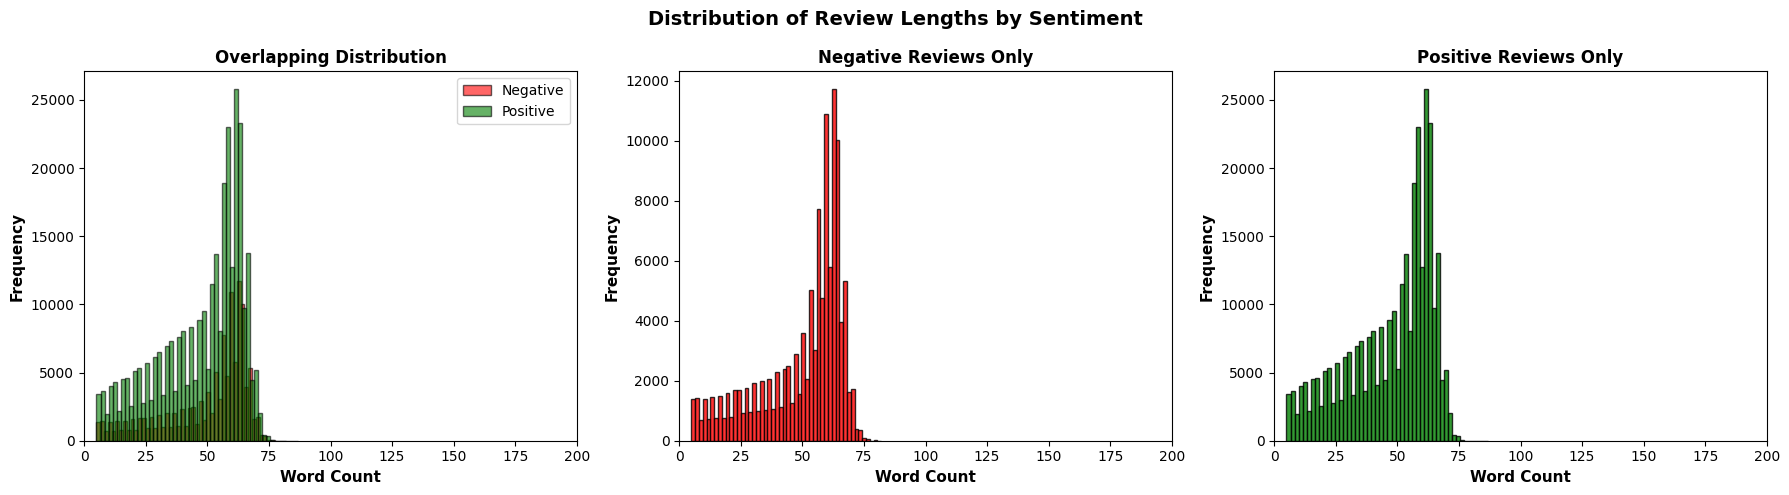

Word count statistics by sentiment:

NEGATIVE REVIEWS:
count    120579.000000
mean         49.805936
std          17.069877
min           5.000000
25%          40.000000
50%          57.000000
75%          62.000000
max          82.000000
Name: word_count, dtype: float64

POSITIVE REVIEWS:
count    316319.000000
mean         47.240207
std          17.144488
min           5.000000
25%          35.000000
50%          53.000000
75%          61.000000
max          87.000000
Name: word_count, dtype: float64


In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Overlapping histograms with TRANSPARENCY
axes[0].hist(df_modeling[df_modeling['sentiment']==0]['word_count'], 
             bins=50, alpha=0.6, label='Negative', color='red', edgecolor='black')
axes[0].hist(df_modeling[df_modeling['sentiment']==1]['word_count'], 
             bins=50, alpha=0.6, label='Positive', color='green', edgecolor='black')
axes[0].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Overlapping Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 200)

# Plot 2: Separate histograms
axes[1].hist(df_modeling[df_modeling['sentiment']==0]['word_count'], 
             bins=50, alpha=0.8, color='red', edgecolor='black')
axes[1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Negative Reviews Only', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 200)

axes[2].hist(df_modeling[df_modeling['sentiment']==1]['word_count'], 
             bins=50, alpha=0.8, color='green', edgecolor='black')
axes[2].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title('Positive Reviews Only', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 200)

plt.suptitle('Distribution of Review Lengths by Sentiment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print("Word count statistics by sentiment:")
print("\nNEGATIVE REVIEWS:")
print(df_modeling[df_modeling['sentiment']==0]['word_count'].describe())
print("\nPOSITIVE REVIEWS:")
print(df_modeling[df_modeling['sentiment']==1]['word_count'].describe())

/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_75872/3561641859.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot,


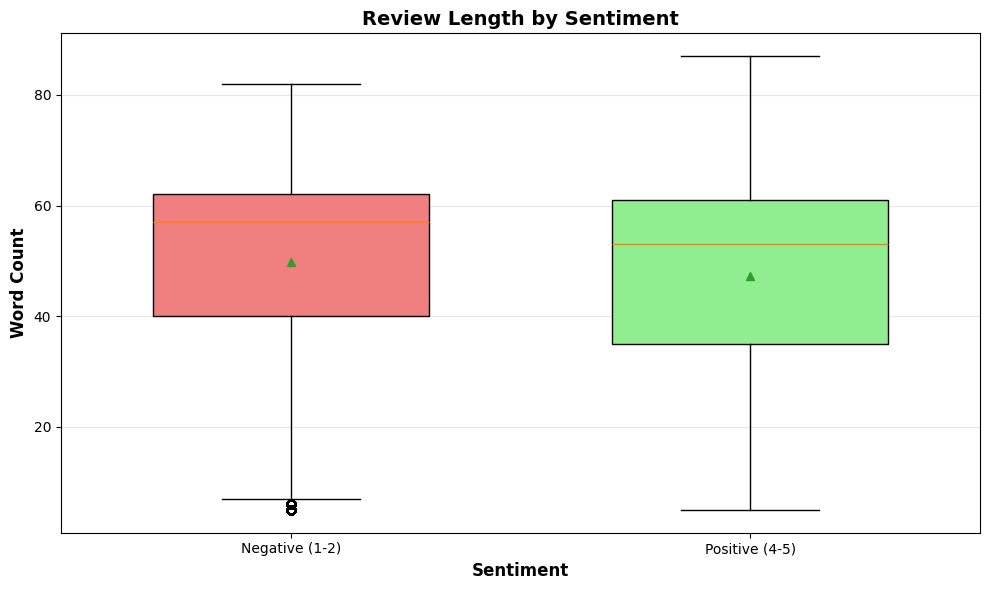

Negative median: 57.0
Positive median: 53.0


In [21]:
# box plot
plt.figure(figsize=(10, 6))

data_to_plot = [
    df_modeling[df_modeling['sentiment']==0]['word_count'],
    df_modeling[df_modeling['sentiment']==1]['word_count']
]

bp = plt.boxplot(data_to_plot, 
                 labels=['Negative (1-2)', 'Positive (4-5)'],
                 patch_artist=True, 
                 widths=0.6,
                 showmeans=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')

plt.ylabel('Word Count', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12, fontweight='bold')
plt.title('Review Length by Sentiment', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Negative median:", df_modeling[df_modeling['sentiment']==0]['word_count'].median())
print("Positive median:", df_modeling[df_modeling['sentiment']==1]['word_count'].median())